# Gradient Boosting Desicion Tree

En las clases anteriores, observamos cómo las mejoras en los algoritmos y las optimizaciones pueden generar avances significativos en la ganancia. Ya hemos logrado un progreso considerable con los modelos de Random Forest. Hoy, daremos un paso aún más grande al explorar los modelos que actualmente están obteniendo los mejores resultados en este tipo de dominios.

Antes que nada, carguemos el entorno de trabajo


In [1]:
%pip install scikit-learn==1.3.2
%pip install seaborn==0.13.1
%pip install numpy==1.26.4
%pip install matplotlib==3.7.1
%pip install pandas==2.1.4
%pip install lightgbm==4.4.0
%pip install optuna==3.6.1

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

base_path = './dmeyf2024/src/monday/'
dataset_path = base_path + 'datos/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'

ganancia_acierto = 273000
costo_estimulo = 7000


# agregue sus semillas
semillas = [555029, 555041, 555043, 555053, 555073]

data = pd.read_csv(dataset_path + dataset_file)

In [4]:
mes_train = 202104
mes_test = 202106

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


In [5]:
data.head()

numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
0          249667857    202101               1            0         0   
1          249667857    202102               1            0         0   
2          249667857    202103               1            0         0   
3          249667857    202104               1            0         0   
4          249667857    202105               1            0         0   

   cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
0            79                  68        2479.93              56664.62   
1            79                  69        3213.23              54528.47   
2            79                  70        6404.48              55195.70   
3            79                  71        5430.67              55893.62   
4            79                  72        3723.86              53480.16   

   mcomisiones  ...  Visa_fultimo_cierre  Visa_mpagado  Visa_mpagospesos  \
0      3774.29  ...                 25.0      44238.07         -50488.61   
1      3498.16  ...                 18.0      77686.82         -44238.07   
2      4612.71  ...                 21.0      70519.14         -77686.82   
3      4673.99  ...                 23.0      47442.89         -70519.14   
4      4395.07  ...                 26.0      68765.04         -47442.89   

   Visa_mpagosdolares  Visa_fechaalta  Visa_mconsumototal  Visa_cconsumos  \
0                 0.0          1908.0            31985.48            12.0   
1                 0.0          1936.0            61647.57            19.0   
2                 0.0          1967.0            51918.80            14.0   
3                 0.0          1997.0            26420.46            10.0   
4                 0.0          2028.0            52738.36            11.0   

   Visa_cadelantosefectivo  Visa_mpagominimo  clase_ternaria  
0                      0.0           2909.04        CONTINUA  
1                      0.0           4692.00        CONTINUA  
2                      0.0           4551.24        CONTINUA  
3                      0.0           3143.64        CONTINUA  
4                      0.0           4398.75          BAJA+1  

[5 rows x 155 columns]

In [6]:
data.columns.to_list()

['numero_de_cliente',
 'foto_mes',
 'active_quarter',
 'cliente_vip',
 'internet',
 'cliente_edad',
 'cliente_antiguedad',
 'mrentabilidad',
 'mrentabilidad_annual',
 'mcomisiones',
 'mactivos_margen',
 'mpasivos_margen',
 'cproductos',
 'tcuentas',
 'ccuenta_corriente',
 'mcuenta_corriente_adicional',
 'mcuenta_corriente',
 'ccaja_ahorro',
 'mcaja_ahorro',
 'mcaja_ahorro_adicional',
 'mcaja_ahorro_dolares',
 'cdescubierto_preacordado',
 'mcuentas_saldo',
 'ctarjeta_debito',
 'ctarjeta_debito_transacciones',
 'mautoservicio',
 'ctarjeta_visa',
 'ctarjeta_visa_transacciones',
 'mtarjeta_visa_consumo',
 'ctarjeta_master',
 'ctarjeta_master_transacciones',
 'mtarjeta_master_consumo',
 'cprestamos_personales',
 'mprestamos_personales',
 'cprestamos_prendarios',
 'mprestamos_prendarios',
 'cprestamos_hipotecarios',
 'mprestamos_hipotecarios',
 'cplazo_fijo',
 'mplazo_fijo_dolares',
 'mplazo_fijo_pesos',
 'cinversion1',
 'minversion1_pesos',
 'minversion1_dolares',
 'cinversion2',
 'minversi

In [7]:
data.drop(['cprestamos_personales', 'mprestamos_personales'], axis=1, inplace=True)

In [8]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

Además, como se mencionó en la clase pasada, comenzaremos a experimentar con nuevas clases para ajustar el modelo. En particular, sumaremos la clase **BAJA+1**, que es estructuralmente muy similar a **BAJA+2**, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [9]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [10]:
valores_unicos = data['clase_ternaria'].unique()

In [11]:
print(valores_unicos)

['CONTINUA' 'BAJA+1' 'BAJA+2']


Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

In [12]:
data.head()

numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
0          249667857    202101               1            0         0   
1          249667857    202102               1            0         0   
2          249667857    202103               1            0         0   
3          249667857    202104               1            0         0   
4          249667857    202105               1            0         0   

   cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
0            79                  68        2479.93              56664.62   
1            79                  69        3213.23              54528.47   
2            79                  70        6404.48              55195.70   
3            79                  71        5430.67              55893.62   
4            79                  72        3723.86              53480.16   

   mcomisiones  ...  Visa_mpagosdolares  Visa_fechaalta  Visa_mconsumototal  \
0      3774.29  ...                 0.0          1908.0            31985.48   
1      3498.16  ...                 0.0          1936.0            61647.57   
2      4612.71  ...                 0.0          1967.0            51918.80   
3      4673.99  ...                 0.0          1997.0            26420.46   
4      4395.07  ...                 0.0          2028.0            52738.36   

   Visa_cconsumos  Visa_cadelantosefectivo  Visa_mpagominimo  clase_ternaria  \
0            12.0                      0.0           2909.04        CONTINUA   
1            19.0                      0.0           4692.00        CONTINUA   
2            14.0                      0.0           4551.24        CONTINUA   
3            10.0                      0.0           3143.64        CONTINUA   
4            11.0                      0.0           4398.75          BAJA+1   

   clase_peso  clase_binaria1  clase_binaria2  
0     1.00000               0               0  
1     1.00000               0               0  
2     1.00000               0               0  
3     1.00000               0               0  
4     1.00001               0               1  

[5 rows x 156 columns]

In [13]:
train_data = data[data['foto_mes'] == mes_train]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']


In [14]:
test_data.head()

numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
5           249667857    202106               1            0         0   
11          250095211    202106               1            0         0   
17          250305092    202106               1            0         0   
23          251706027    202106               1            0         0   
29          252325755    202106               1            0         0   

    cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
5             79                  73        4526.72              57164.38   
11            62                 308        2544.50              30880.66   
17            57                 201       -3771.25              20589.48   
23            49                 128        3807.52              47643.35   
29            60                 325       26000.62             112762.06   

    mcomisiones  ...  Visa_mpagosdolares  Visa_fechaalta  Visa_mconsumototal  \
5       4308.22  ...                 0.0          2058.0            86416.56   
11      1190.43  ...                 0.0          5820.0                0.00   
17       496.76  ...                 0.0          4384.0             5988.85   
23      2723.56  ...                 0.0          3754.0            43582.40   
29       721.75  ...                 0.0          7980.0             4218.75   

    Visa_cconsumos  Visa_cadelantosefectivo  Visa_mpagominimo  clase_ternaria  \
5             14.0                      0.0           5841.54          BAJA+1   
11             0.0                      0.0           1184.73          BAJA+1   
17             5.0                      0.0           5243.31          BAJA+1   
23            16.0                      0.0           2498.49          BAJA+1   
29             3.0                      0.0            926.67          BAJA+1   

    clase_peso  clase_binaria1  clase_binaria2  
5      1.00001               0               1  
11     1.00001               0               1  
17     1.00001               0               1  
23     1.00001               0               1  
29     1.00001               0               1  

[5 rows x 156 columns]

In [15]:
train_data.head()

numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
3           249667857    202104               1            0         0   
9           250095211    202104               1            0         0   
15          250305092    202104               1            0         0   
21          251706027    202104               1            0         0   
27          252325755    202104               1            0         0   

    cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
3             79                  71        5430.67              55893.62   
9             62                 306        2252.52              30369.69   
15            56                 199        3050.97              34365.59   
21            49                 126        1560.30              53346.06   
27            60                 323       13605.13              78209.64   

    mcomisiones  ...  Visa_mpagosdolares  Visa_fechaalta  Visa_mconsumototal  \
3       4673.99  ...                 0.0          1997.0            26420.46   
9       1382.22  ...                 0.0          5759.0             8124.08   
15      1561.90  ...                 0.0          4323.0             5964.44   
21      2566.37  ...                 0.0          3693.0            34377.39   
27       912.45  ...                 0.0          7919.0             3453.12   

    Visa_cconsumos  Visa_cadelantosefectivo  Visa_mpagominimo  clase_ternaria  \
3             10.0                      0.0           3143.64        CONTINUA   
9              3.0                      0.0           1055.70        CONTINUA   
15             5.0                      0.0           5360.61        CONTINUA   
21            12.0                      0.0           1067.43        CONTINUA   
27             2.0                      0.0           1759.50        CONTINUA   

    clase_peso  clase_binaria1  clase_binaria2  
3          1.0               0               0  
9          1.0               0               0  
15         1.0               0               0  
21         1.0               0               0  
27         1.0               0               0  

[5 rows x 156 columns]

Y preparamos el *dataset* para poder usar el **rf** de una clase anterior.

In [16]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
Xif = imp_mean.fit_transform(X_test)

Comenzaremos explicando el funcionamiento del protagonista de esta clase: **LightGBM**. Primero, partiremos con una revisión de cómo funciona el algoritmo en el que se basa, **XGBoost**. Para una introducción completa, puedes consultar este

https://xgboost.readthedocs.io/en/stable/tutorials/model.html.

Aunque en la cátedra no somos grandes seguidores de Josh Starmer y su canal *StatQuest*, reconozco que sus series sobre *Gradient Boosting* y *XGBoost* son excelentes recursos. Aquí te dejamos los enlaces a esas dos series que realmente valen la pena:

[Serie Gradient Boosting](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

[Serie XGBoost](https://www.youtube.com/watch?v=OtD8wVaFm6E&list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ)

Finalmente, analizaremos las diferencias clave que ofrece **LightGBM** frente a XGBoost. Puedes explorar más sobre ello en este https://lightgbm.readthedocs.io/en/stable/Features.html.

No olvides tener a mano la [documentación de LightGBM](https://lightgbm.readthedocs.io/)y la [lista completa de sus parámetros](https://lightgbm.readthedocs.io/en/latest/Parameters.html).

Este es un algoritmo muy usado en el mercado, recomiendo dedicarle el tiempo necesario para aprenderlo bien.

Vamos a utilizar el algoritmo directamente, sin pasar por *scikit-learn*. Sin embargo, si algún alumno lo prefiere, puede optar por usar el *wrapper* de sklearn para este caso.

Para evaluar la calidad del modelo, crearemos nuestra propia función de evaluación que calcule la ganancia. La razón de incluir los pesos es precisamente para poder implementar esta función de evaluación de manera adecuada. Al combinar las clases *BAJA+1* y *BAJA+2* en una sola, necesitamos una forma de diferenciarlas, y es aquí donde entra en juego el *weight*. Este parámetro nos permitirá distinguir entre ambas clases al momento de evaluarlas dentro del algoritmo.


In [17]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

LGBM necesita su propio tipo de Datasets:

In [18]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train)
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

A continuación, compararemos las dos clases. Utilizaremos para medir la calidad de las clases (y de los parámetros), la función **cv** que viene *out-of-the-box*

In [19]:
cv_results1 = lgb.cv(
    params,
    train_data1,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

cv_results2 = lgb.cv(
    params,
    train_data2,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

Y vizualizamos los resultados de ambas ejecuciones:

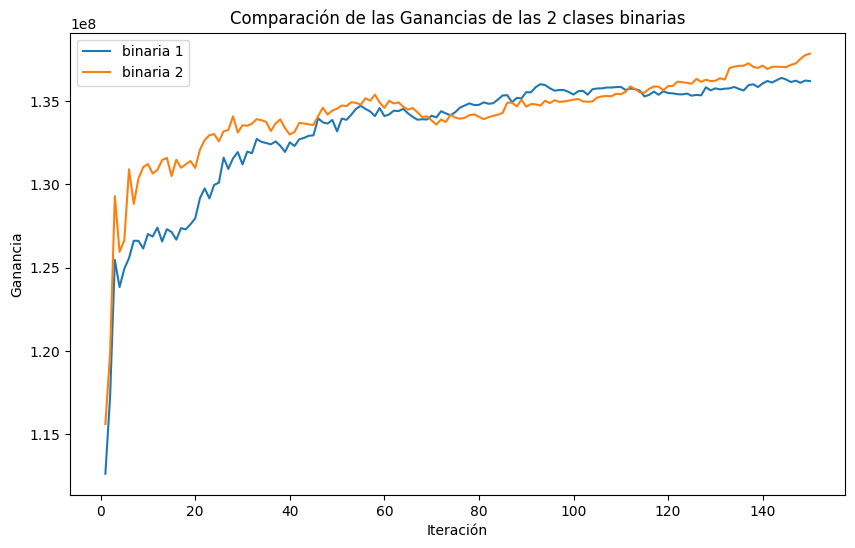

In [20]:
df_ganancias = pd.DataFrame({
    'binaria1': cv_results1['valid gan_eval-mean'],
    'binaria2': cv_results2['valid gan_eval-mean'],
    'Iteracion': range(1, len(cv_results1['valid gan_eval-mean']) + 1)
})

# Normalizamos la ganancias
df_ganancias['binaria1'] = df_ganancias['binaria1']*5
df_ganancias['binaria2'] = df_ganancias['binaria2']*5

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, label='binaria 1')
sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, label='binaria 2')
plt.title('Comparación de las Ganancias de las 2 clases binarias')
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


Se observa una ligera mejora al combinar las clases en modelos sencillos. Dado que cada pequeña mejora es importante, continuaremos utilizando esta estrategia.

A continuación, procederemos a optimizar **LightGBM** utilizando la librería **Optuna**. Cabe destacar que las optimizaciones que realizaremos son básicas y están diseñadas para ejecutarse en pocos minutos. Será su responsabilidad ampliar tanto el rango de búsqueda como el tiempo de optimización para obtener un modelo más competitivo.


In [21]:

def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 70, 150),
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 500, 2000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100, # modificar, subit y subir... y descomentar la línea inferior
        # early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_301_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-10-13 23:08:25,409] Using an existing study with name 'exp_301_lgbm' instead of creating a new one.


In [22]:
new_var = study.optimize(objective, n_trials=100)
new_var

[I 2024-10-13 23:09:04,921] Trial 93 finished with value: 152488000.0 and parameters: {'num_leaves': 77, 'learning_rate': 0.05058252541636471, 'min_data_in_leaf': 831, 'feature_fraction': 0.9137249081781841, 'bagging_fraction': 0.11748405767137879}. Best is trial 32 with value: 156303000.0.
[I 2024-10-13 23:09:27,282] Trial 94 finished with value: 153188000.0 and parameters: {'num_leaves': 75, 'learning_rate': 0.04489943131111058, 'min_data_in_leaf': 747, 'feature_fraction': 0.9391071314547036, 'bagging_fraction': 0.22067864891580413}. Best is trial 32 with value: 156303000.0.
[I 2024-10-13 23:09:42,587] Trial 95 finished with value: 150731000.0 and parameters: {'num_leaves': 74, 'learning_rate': 0.04554631240575746, 'min_data_in_leaf': 635, 'feature_fraction': 0.9388483576193476, 'bagging_fraction': 0.20983212894634484}. Best is trial 32 with value: 156303000.0.
[W 2024-10-13 23:09:49,155] Trial 96 failed with parameters: {'num_leaves': 77, 'learning_rate': 0.04227286646419231, 'min_d

KeyboardInterrupt: 

Analizamos los resultados as usual

In [23]:
optuna.visualization.plot_optimization_history(study)

KeyboardInterrupt: 

In [24]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [25]:
plot_slice(study)

In [26]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=1400, height=800)  # Ajusta según tus necesidades
fig.show()

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [27]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 86


Observamos la variables más importantes para el modelo:

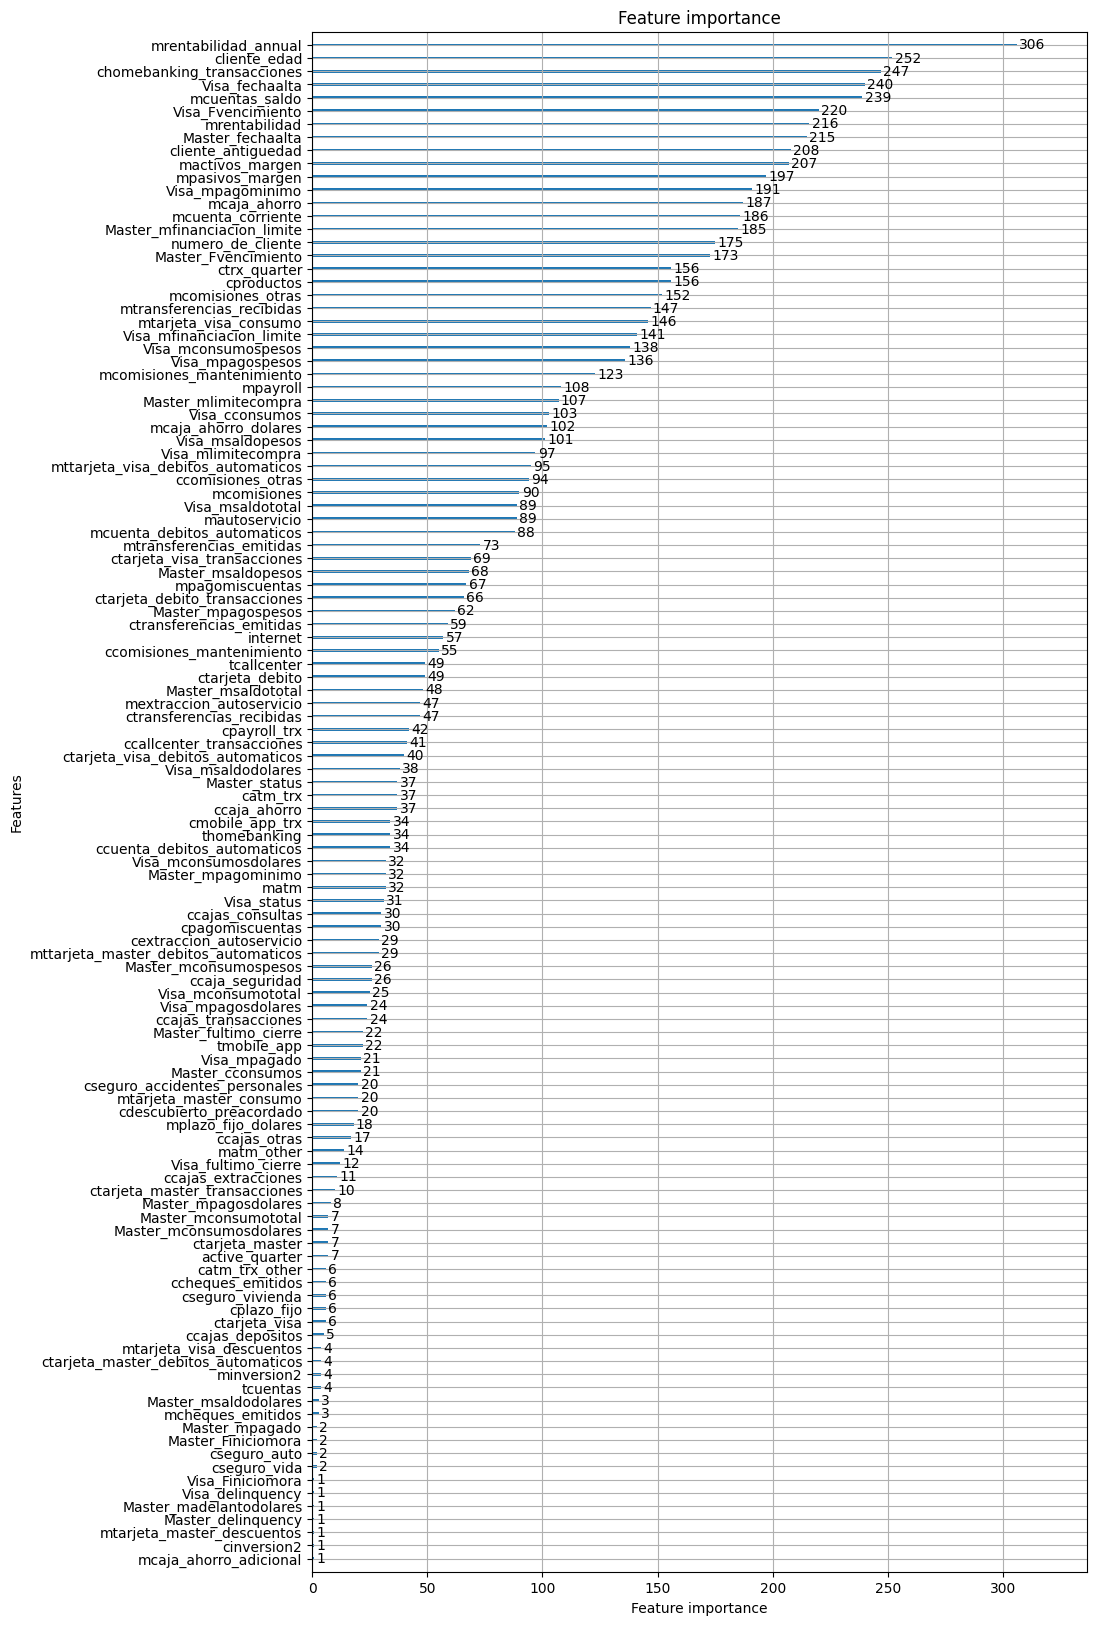

In [28]:
lgb.plot_importance(model, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [29]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


feature  importance
8          mrentabilidad_annual         306
5                  cliente_edad         252
95   chomebanking_transacciones         247
147              Visa_fechaalta         240
22               mcuentas_saldo         239
..                          ...         ...
130            Visa_delinquency           1
108          Master_delinquency           1
42                  cinversion2           1
134            Visa_Finiciomora           1
68   mtarjeta_master_descuentos           1

[116 rows x 2 columns]

Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [30]:
model.save_model(modelos_path + 'lgb_first.txt')

Y recuperar el mismo desde ese formato

In [31]:
model = lgb.Booster(model_file=modelos_path + 'lgb_first.txt')

Y sobre ambos modelos obtenemos la predicción de **Abril**

In [32]:
y_pred_lgm = model.predict(X_test)

In [33]:
print(y_pred_lgm)

[0.00276625 0.00044246 0.00051701 ... 0.0008228  0.00125148 0.02155617]


In [59]:
# X_test = X_test.drop(['y_pred_proba', 'y_pred_binary'], axis=1)

In [60]:
y_pred_proba = model.predict(X_test)
y_pred_binary = (y_pred_proba >= 0.025).astype(int)
X_test['y_pred_proba'] = y_pred_proba
X_test['y_pred_binary'] = y_pred_binary

In [61]:
X_test.head()

numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
5           249667857    202106               1            0         0   
11          250095211    202106               1            0         0   
17          250305092    202106               1            0         0   
23          251706027    202106               1            0         0   
29          252325755    202106               1            0         0   

    cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
5             79                  73        4526.72              57164.38   
11            62                 308        2544.50              30880.66   
17            57                 201       -3771.25              20589.48   
23            49                 128        3807.52              47643.35   
29            60                 325       26000.62             112762.06   

    mcomisiones  ...  Visa_mpagado  Visa_mpagospesos  Visa_mpagosdolares  \
5       4308.22  ...     101863.03         -68765.04                 0.0   
11      1190.43  ...          0.00         -16252.85                 0.0   
17       496.76  ...          0.00         -40189.53                 0.0   
23      2723.56  ...          0.00         -51983.43                 0.0   
29       721.75  ...          0.00          -7745.54                 0.0   

    Visa_fechaalta  Visa_mconsumototal  Visa_cconsumos  \
5           2058.0            86416.56            14.0   
11          5820.0                0.00             0.0   
17          4384.0             5988.85             5.0   
23          3754.0            43582.40            16.0   
29          7980.0             4218.75             3.0   

    Visa_cadelantosefectivo  Visa_mpagominimo  y_pred_proba  y_pred_binary  
5                       0.0           5841.54      0.002766              0  
11                      0.0           1184.73      0.000442              0  
17                      0.0           5243.31      0.000517              0  
23                      0.0           2498.49      0.002125              0  
29                      0.0            926.67      0.001181              0  

[5 rows x 154 columns]

In [62]:
df_solucion = X_test[['numero_de_cliente', 'y_pred_binary']]
df_solucion.rename(columns={'y_pred_binary': 'Predicted'}, inplace=True)

C:\Users\Nicolas Girado\AppData\Local\Temp\ipykernel_20884\1345157249.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
df_solucion.head()

numero_de_cliente  Predicted
5           249667857          0
11          250095211          0
17          250305092          0
23          251706027          0
29          252325755          0

In [64]:
df_solucion.to_csv(dataset_path + "solucion.csv", index=False)